# Show how patch size affects entropy estimates

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

import matplotlib.pyplot as plt
from bsccm import BSCCM

import time
from tqdm import tqdm
import jax.numpy as np
import numpy as onp
from cleanplots import *
from led_array.bsccm_utils import *
from plot_utils import *
from image_utils import *

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')


Opening BSCCM
Opened BSCCM


: 

In [6]:
# num_images = 20000
# num_patches = 50000
num_images = 2000
num_patches = 5000

num_patches_to_show = 7
channels = ['LED119', 'DPC_Right', 'Brightfield']
patch_sizes = np.linspace(5, 60, 6).astype(int)

patch_sizes = [5, 10]

eigenvalue_fig, eigenvalue_ax = plt.subplots(len(patch_sizes), 1, figsize=(6, 5 * len(patch_sizes)))
rates_fig, rates_ax = plt.subplots(1, 1, figsize=(6, 4))
ev_hists = {patch_size: OverlayedHistograms(ax=ax, bins=b) for patch_size, ax, b in 
                zip(patch_sizes, eigenvalue_ax, np.linspace(12, 40, len(patch_sizes)).astype(int))}
example_patch_figs = {}
example_patch_axes_all = {}
for patch_size in patch_sizes:
    example_patch_fig, example_patch_axes = plt.subplots( len(channels), 
                                        num_patches_to_show, figsize=(3.5 * num_patches_to_show, 3.5 * len(channels)))
    example_patch_figs[patch_size] = example_patch_fig
    example_patch_axes_all[patch_size] = example_patch_axes


photon_rescale_fractions = compute_photon_rescale_fraction(bsccm, channels, verbose=True)

entropy_per_pixel = {channel: [] for channel in channels}
mutual_information_per_pixel = {channel: [] for channel in channels}

for channel in channels:
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=32, convert_units_to_photons=True)
    for patch_size_index, patch_size in enumerate(patch_sizes):
        photon_scaled_patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
        photon_scaled_patches = add_shot_noise_to_experimenal_data(photon_scaled_patches, photon_rescale_fractions[channel])
        photon_scaled_eigenvalues = compute_eigenvalues(photon_scaled_patches)

        ev_hists[patch_size].add(photon_scaled_eigenvalues, label=get_display_channel_names(channel))
        
        clear_spines(eigenvalue_ax[patch_size_index])
        eigenvalue_ax[patch_size_index].set(xlabel=f'Eigenvalues ({patch_size}x{patch_size} patches)', ylabel='Count')

        example_patch_fig = example_patch_figs[patch_size]
        example_patch_axes = example_patch_axes_all[patch_size]
        patch_row_index =  channels.index(channel)
        for j in range(num_patches_to_show):
            im = example_patch_axes[patch_row_index, j].imshow(photon_scaled_patches[j], cmap='inferno', interpolation='nearest')
            clear_spines(example_patch_axes[patch_row_index, j], all=True)
            example_patch_axes[patch_row_index, j].set(xticks=[], yticks=[])
        example_patch_axes[patch_row_index, 0].set_ylabel(f'{get_display_channel_names(channel)}')

        raise Exception('Reimplement when mutual information estimators ready')
        entropy_per_pixel, mutual_information_per_pixel = estimate_entropy_and_mutual_information(photon_scaled_patches, photon_scaled_eigenvalues)
        print(f'Channel: {channel}, patch size: {patch_size}, entropy: {entropy_per_pixel}, mutual information: {mutual_information_per_pixel}')
    rates_ax.plot(patch_sizes, np.array(mutual_information_per_pixel[channel]), '-o', label=get_display_channel_names(channel))

for patch_size_index, patch_size in enumerate(patch_sizes):
    ev_hists[patch_size].plot()
    ev_hists[patch_size].ax.set(xlabel=f'Eigenvalues ({patch_size}x{patch_size} patches)', ylabel='Count')
eigenvalue_ax[0].legend()

rates_ax.set(xlabel='Patch size (pixels)', ylabel='Mutual information (Bits per pixel)',)
clear_spines(rates_ax)
rates_ax.legend()

rates_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'patch_size_entropy_rates_by_channel' + '.pdf', transparent=True)
eigenvalue_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'patch_size_eigenvalue_hist' + '.pdf', transparent=True)

for patch_size in patch_sizes:
    example_patch_figs[patch_size].savefig('/home/hpinkard_waller/figures/entropy_rates/' + f'patch_size_{patch_size}_example_patches' + '.pdf', transparent=True)

100%|██████████| 1000/1000 [00:00<00:00, 1762.21it/s]


phtons per pixel:  {'LED119': Array(385.99353, dtype=float32), 'DF_50': Array(335.38556, dtype=float32), 'DPC_Right': Array(1054.7169, dtype=float32), 'Brightfield': Array(1634.5032, dtype=float32)}
Rescale to fraction:  {'LED119': Array(0.8688891, dtype=float32), 'DF_50': Array(1., dtype=float32), 'DPC_Right': Array(0.31798634, dtype=float32), 'Brightfield': Array(0.20519114, dtype=float32)}


 13%|█▎        | 6343/50000 [00:08<00:57, 753.38it/s]

In [4]:
dim = np.prod(photon_scaled_patches.shape[1:])
differential_entropy = dim / 2 * np.log2(2 * np.pi * np.e) + 0.5 * np.sum(np.log2(photon_scaled_eigenvalues))
discrete_entropy = differential_entropy - dim * np.log2(1) # discreteization interval is one photon
entropy_per_pix = discrete_entropy / dim

N = photon_scaled_patches.shape[0]
conditional_entropy_per_pix_differential = ((dim * np.log2(2 * np.pi * np.e)) + (dim / 2 / N) * np.sum(np.log2(photon_scaled_eigenvalues))) / dim
conditional_entropy_per_pix_discrete = conditional_entropy_per_pix_differential - np.log2(1)

# entropy_per_pixel[channel].append(entropy_per_pix)
# mutual_information_per_pixel[channel] = entropy_per_pix - conditional_entropy_per_pix_discrete
print(entropy_per_pix)
print(conditional_entropy_per_pix_discrete)


6.624621830297829
4.09647993348384


# Same thing but for backgrounds

100%|██████████████████████████████| 1000/1000 [00:01<00:00, 537.84it/s]


phtons per pixel:  {'LED119': Array(212.13286, dtype=float32), 'DF_50': Array(125.12549, dtype=float32), 'DPC_Right': Array(1192.558, dtype=float32), 'Brightfield': Array(1778.8358, dtype=float32)}
Rescale to fraction:  {'LED119': Array(0.58984494, dtype=float32), 'DF_50': Array(1., dtype=float32), 'DPC_Right': Array(0.10492193, dtype=float32), 'Brightfield': Array(0.07034122, dtype=float32)}


100%|██████████████████████████████████████| 50000/50000 [01:06<00:00, 747.57it/s]


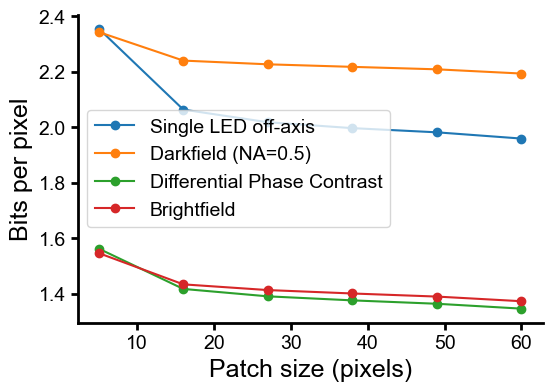

In [3]:
num_images = 20000
num_patches = 50000

# num_images = 2000
# num_patches = 5000

num_patches_to_show = 7
channels = ['LED119', 'DPC_Right', 'Brightfield']
patch_sizes = np.linspace(5, 60, 6).astype(int)

rates_fig, rates_ax = plt.subplots(1, 1, figsize=(6, 4))


photon_rescale_fractions = compute_photon_rescale_fraction(bsccm, channels, verbose=True, empty_slides=True)

entropy_per_pixel_bakground = {channel: [] for channel in channels}

for channel in channels:
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=32, empty_slides=True, convert_units_to_photons=True)
    for patch_size_index, patch_size in enumerate(patch_sizes):
        photon_scaled_patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
        photon_scaled_patches *= photon_rescale_fractions[channel]

        photon_scaled_eigenvalues = compute_eigenvalues(photon_scaled_patches)

        dim = np.prod(photon_scaled_patches.shape[1:])
        differential_entropy = dim / 2 * np.log(2 * np.pi * np.e) + 0.5 * np.sum(np.log(photon_scaled_eigenvalues))
        discrete_entropy = (dim * np.log(1) + differential_entropy) * np.log2(np.e) # discreteization interval is one photon
        entropy_per_pix = discrete_entropy / dim
        entropy_per_pixel_bakground[channel].append(discrete_entropy / dim)


    rates_ax.plot(patch_sizes, np.array(entropy_per_pixel_bakground[channel]), '-o', label=get_display_channel_names(channel))

rates_ax.set(xlabel='Patch size (pixels)', ylabel='Bits per pixel')
clear_spines(rates_ax)
rates_ax.legend()

rates_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'patch_size_bakground_entropy_rates_by_channel' + '.pdf', transparent=True)


# Compare background entropy vs entropy with sample


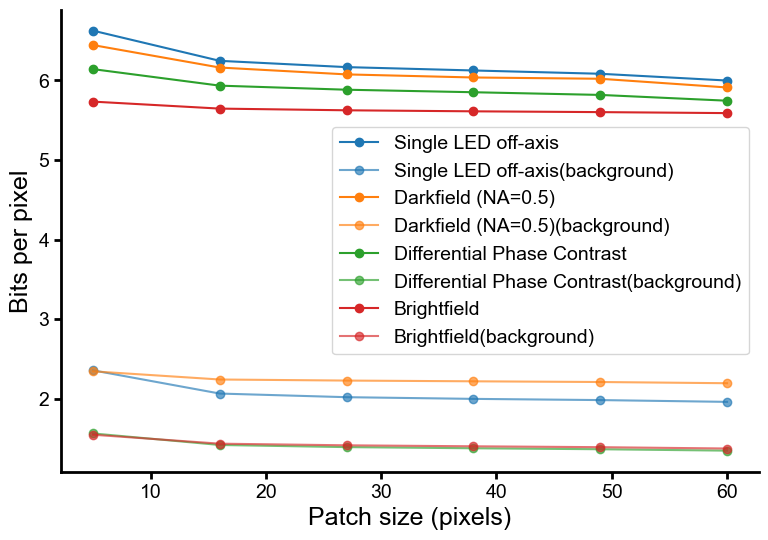

In [4]:
rates_fig, rates_ax = plt.subplots(1, 1, figsize=(9, 6))

# get the first 4 defualt matplotlib colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]
for i, channel in enumerate(channels):
    rates_ax.plot(patch_sizes, np.array(entropy_per_pixel[channel]), '-o',
                   label=get_display_channel_names(channel), alpha=1, color=colors[i])
    rates_ax.plot(patch_sizes, np.array(entropy_per_pixel_bakground[channel]), '-o', 
           label=get_display_channel_names(channel) + '(background)', alpha=0.65, color=colors[i])



rates_ax.set(xlabel='Patch size (pixels)', ylabel='Bits per pixel')
clear_spines(rates_ax)
rates_ax.legend()

rates_fig.savefig('/home/hpinkard_waller/figures/entropy_rates/' + 'patch_size_background_and_object_entropy_rates_by_channel' + '.pdf', transparent=True)
